In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from pytorch_forecasting import TimeSeriesDataSet, TemporalFusionTransformer
import pytorch_lightning as pl
import seaborn as sns

# Description of the target variable (number of pickup)

In [2]:
# # Ignore warnings
# import warnings
# warnings.filterwarnings("ignore")

In [3]:
df = pd.read_csv('dataset/locker_nyc_engineered.csv')
# Convert Date Hour to datetime
df['Date Hour'] = pd.to_datetime(df['Date Hour'])
df['Locker Name'] = "Total Locker"
# Extract dict Locker Name -> IsIndoor
locker_indoor_dict = df.set_index('Locker Name')['IsIndoor'].to_dict()
# Cache IsHoliday per date
holiday_dict = df.groupby(df['Date Hour'].dt.date)['IsHoliday'].first().to_dict()
df.drop(columns=['IsIndoor'], inplace=True)

# Group by Locker Name, resample to 3 hours, and take the sum of numerical columns
df = df.set_index('Date Hour')
df = df.groupby('Locker Name').resample('3h').sum().drop(columns=["Locker Name"])
df = df.reset_index()
df = df.fillna(0)

# Map IsHoliday back to the resampled dataframe
df['IsHoliday'] = df['Date Hour'].dt.date.map(holiday_dict)

# Apply rolling window
for window in [1, 2]:
    df[f'withdraw_{window}'] = df.groupby('Locker Name')['size_S_withdraw'].transform(lambda x: x.shift(1).rolling(window=window, min_periods=1).sum())
    # Fill NaN values with 0
    df[f'withdraw_{window}'] = df[f'withdraw_{window}'].fillna(0)

# Apply rolling window
for window in [1, 2, 8, 16]:
    df[f'delivery_{window}'] = df.groupby('Locker Name')['size_S_delivery'].transform(lambda x: x.rolling(window=window, min_periods=1).sum())

# Proxy inventory by applying rolling window sum of withdraw - delivery
df[f'inventory'] = df[f'delivery_1'] - df[f'withdraw_1']
# Apply cumulative sum to get a proxy inventory level
df[f'inventory'] = df.groupby('Locker Name')[f'inventory'].cumsum()

# Target variable: proportion_withdraw: size_S_withdraw / inventory
df['proportion_withdraw'] = df.apply(lambda row: row['size_S_withdraw'] / row['inventory'] if row['inventory'] > 0 else 0, axis=1)
df.drop(columns=['size_S_withdraw'], inplace=True)
# Ignore all size_*_delivery and size_*_withdraw columns except size_S_withdraw
cols_to_drop = [col for col in df.columns if ('size_' in col and col not in ['size_S_withdraw'])]
df = df.drop(columns=cols_to_drop)

# Apply the IsIndoor feature back to the resampled dataframe
df['IsIndoor'] = df['Locker Name'].map(locker_indoor_dict)

df['Hour'] = df['Date Hour'].dt.hour
# df['Day of Week'] = df['Date Hour'].dt.dayofweek
df['Month'] = df['Date Hour'].dt.month
df['IsPeakHour'] = df['Date Hour'].apply(lambda x: True if 17 <= x.hour <= 20 else False)
df['IsWeekend'] = df['Date Hour'].dt.dayofweek.apply(lambda x: True if x >= 5 else False)

# Create a time index as incremental integer
df['time_idx'] = df.groupby('Locker Name')['Date Hour'].transform(lambda x: (x - x.min()).dt.total_seconds() // 3600 / 3).astype(int)
df.head()

,Locker Name,Date Hour,IsHoliday,withdraw_1,withdraw_2,delivery_1,delivery_2,delivery_8,delivery_16,inventory,proportion_withdraw,IsIndoor,Hour,Month,IsPeakHour,IsWeekend,time_idx
0,Total Locker,2024-04-10 12:00:00,0.0,0.0,0.0,2.0,2.0,2.0,2.0,2.0,1.0,0,12,4,False,False,0
1,Total Locker,2024-04-10 15:00:00,0.0,2.0,2.0,0.0,2.0,2.0,2.0,0.0,0.0,0,15,4,False,False,1
2,Total Locker,2024-04-10 18:00:00,0.0,0.0,2.0,10.0,10.0,12.0,12.0,10.0,0.1,0,18,4,True,False,2
3,Total Locker,2024-04-10 21:00:00,0.0,1.0,1.0,0.0,10.0,12.0,12.0,9.0,0.0,0,21,4,False,False,3
4,Total Locker,2024-04-11 00:00:00,0.0,0.0,1.0,0.0,0.0,12.0,12.0,9.0,0.0,0,0,4,False,False,4


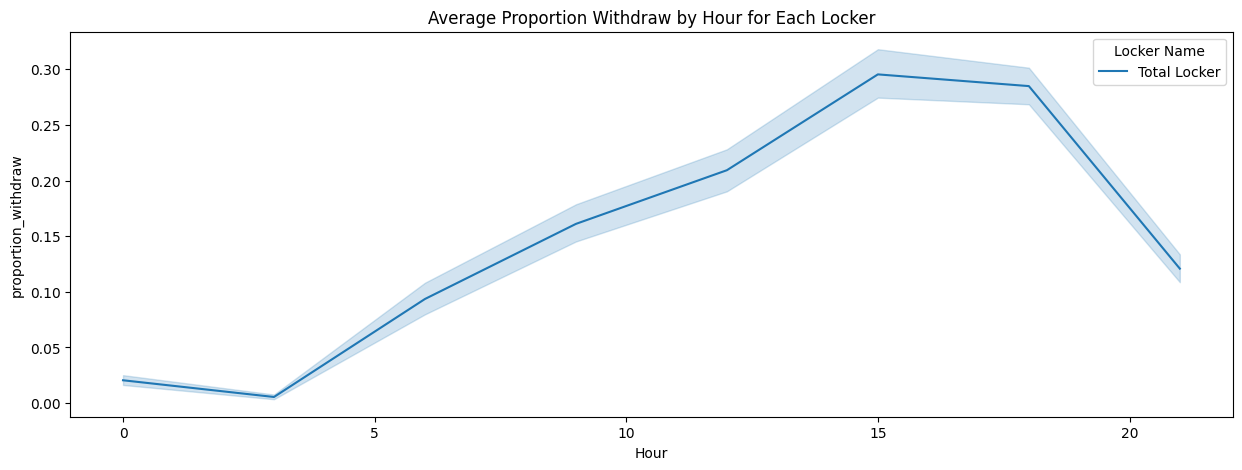

In [4]:
# Plot the proportion_withdraw, mean by hour, for each locker
plt.figure(figsize=(15, 5))
sns.lineplot(data=df, x='Hour', y='proportion_withdraw', hue='Locker Name', estimator='mean')
plt.title('Average Proportion Withdraw by Hour for Each Locker')
plt.show()

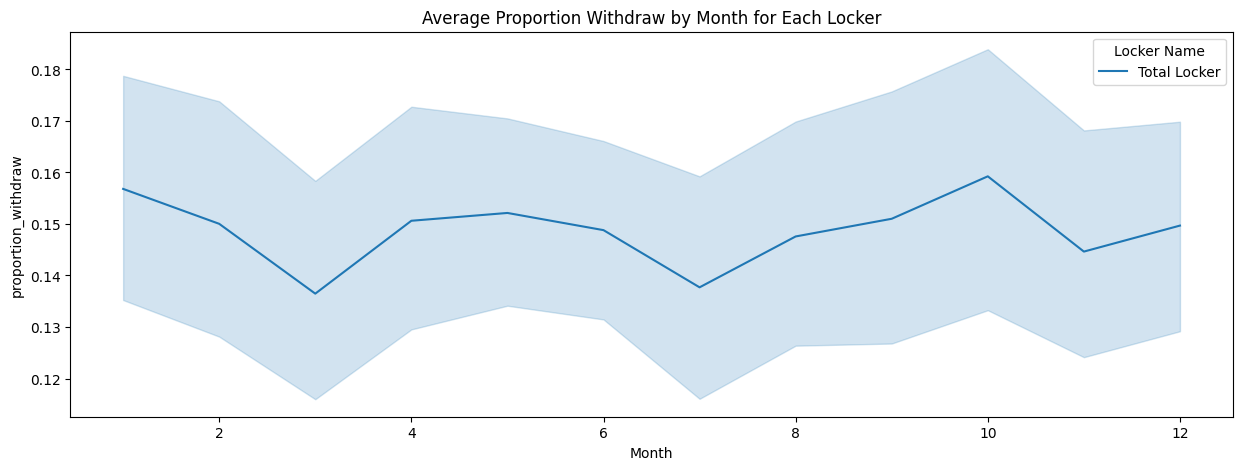

In [5]:
# Plot the proportion_withdraw, mean by hour, for each locker
plt.figure(figsize=(15, 5))
sns.lineplot(data=df, x='Month', y='proportion_withdraw', hue='Locker Name', estimator='mean')
plt.title('Average Proportion Withdraw by Month for Each Locker')
plt.show()

In [6]:
# Print the proportion of zero values in size_S_withdraw
zero_proportion = (df['proportion_withdraw'] == 0).mean()
print(f"Proportion of zero values in size_S_withdraw: {zero_proportion:.2%}")
print(f"Proportion of IsHoliday: {df['IsHoliday'].mean():.2%}")

Proportion of zero values in size_S_withdraw: 41.36%
Proportion of IsHoliday: 2.68%


In [7]:
MONTHS_IN_YEAR = 12
HOURS_IN_DAY = 24
DAYS_IN_WEEK = 7
QUARTERS_IN_YEAR = 4

df['hour_sin'] = np.sin(2 * np.pi * df['Hour'] / HOURS_IN_DAY)
df['hour_cos'] = np.cos(2 * np.pi * df['Hour'] / HOURS_IN_DAY)
# df['month_sin'] = np.sin(2 * np.pi * df['Month'] / MONTHS_IN_YEAR)
# df['month_cos'] = np.cos(2 * np.pi * df['Month'] / MONTHS_IN_YEAR)
# df['day_of_week_sin'] = np.sin(2 * np.pi * df['Day of Week'] / DAYS_IN_WEEK)
# df['day_of_week_cos'] = np.cos(2 * np.pi * df['Day of Week'] / DAYS_IN_WEEK)

df = df.drop(columns=['Hour', 'Month', 'IsHoliday'])


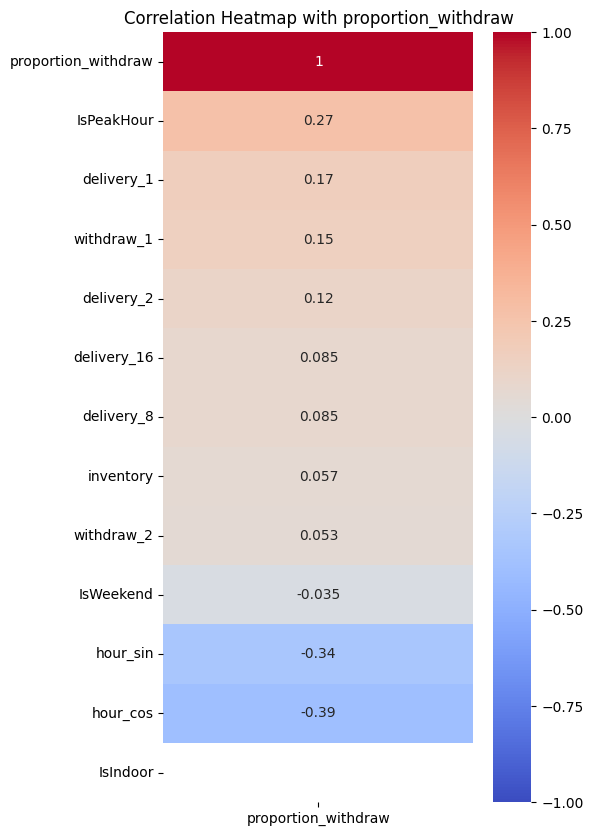

<Figure size 500x1000 with 0 Axes>

<Figure size 500x1000 with 0 Axes>

In [8]:
# Plot the correlation heatmap between size_S_withdraw and other features, except Date Hour and Locker Name
plt.figure(figsize=(5, 10))
COLUMNS_TO_EXCLUDE = ['Date Hour', 'Locker Name', 'time_idx']
df_corr = df.drop(columns=COLUMNS_TO_EXCLUDE)
sns.heatmap(df_corr.corr()[['proportion_withdraw']].sort_values(by='proportion_withdraw', ascending=False), annot=True, cmap='coolwarm', vmin=-1, vmax=1)
plt.title('Correlation Heatmap with proportion_withdraw')
plt.show()
plt.figure(figsize=(5, 10))

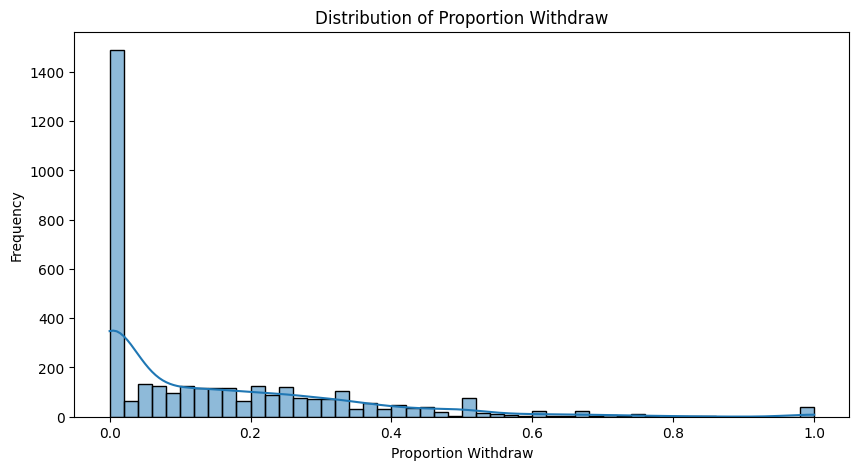

In [9]:
# Plot the proportion_withdraw distribution
plt.figure(figsize=(10, 5))
sns.histplot(df['proportion_withdraw'], bins=50, kde=True)
plt.title('Distribution of Proportion Withdraw')
plt.xlabel('Proportion Withdraw')
plt.ylabel('Frequency')
plt.show()

In [10]:
MIN_ENCODER_LENGTH = 12  # keep encoder length long (as it is in the validation set)
MAX_ENCODER_LENGTH = 72
MIN_PREDICTION_LENGTH = 1
MAX_PREDICTION_LENGTH = 1

# df = df[df["Locker Name"].isin(["508-1"])]

# CATEGORICAL_COLUMNS = ['IsBusinessHour', 'IsPeakHour', 'IsWeekend', 'IsIndoor', 'IsHoliday']
# # Convert categorical columns to string first, then category dtype
# for col in CATEGORICAL_COLUMNS:
#     if col in df.columns:
#         df[col] = df[col].astype(str)

cutoff_dates = {
    locker: df[df['Locker Name'] == locker]['Date Hour'].max() - pd.Timedelta(days=50)
    for locker in df['Locker Name'].unique()
}

train_df = df.loc[~((df['Date Hour'] >= df['Locker Name'].map(cutoff_dates)) & (df['time_idx'] > 0))]
test_df = df.loc[(df['Date Hour'] >= df['Locker Name'].map(cutoff_dates)) & (df['time_idx'] > 0)]

# Cutoff for validation set from train_df
val_cutoff_dates = {
    locker: train_df[train_df['Locker Name'] == locker]['Date Hour'].max() - pd.Timedelta(days=50)
    for locker in train_df['Locker Name'].unique()
}

val_df = train_df.loc[(train_df['Date Hour'] >= train_df['Locker Name'].map(val_cutoff_dates)) & (train_df['time_idx'] > 0)]
train_df = train_df.loc[~((train_df['Date Hour'] >= train_df['Locker Name'].map(val_cutoff_dates)) & (train_df['time_idx'] > 0))]

print("Train shape:", train_df.shape)
print("Val shape:", val_df.shape)
print("Test shape:", test_df.shape)

Train shape: (2793, 16)
Val shape: (401, 16)
Test shape: (401, 16)


In [12]:
from pytorch_forecasting.metrics import NegativeBinomialDistributionLoss, RMSE
from pytorch_forecasting.data.encoders import GroupNormalizer
from pytorch_lightning.callbacks import EarlyStopping

print(f"Train df shape: {train_df.shape}, Val df shape: {val_df.shape}")

WITHDRAW_FEATURES = ['withdraw_1', 'withdraw_2']
DELIVERY_FEATURES = ['delivery_1', 'delivery_2', 'delivery_8', 'delivery_16']

training = TimeSeriesDataSet(
    data = train_df,
    time_idx = "time_idx",
    target="proportion_withdraw",
    group_ids=["Locker Name"],
    # time_varying_known_categoricals=["IsPeakHour", "IsWeekend"],
    time_varying_known_reals=["hour_sin", "hour_cos", "IsPeakHour", "IsWeekend"] + WITHDRAW_FEATURES + DELIVERY_FEATURES,
    allow_missing_timesteps=True,
    min_encoder_length=MIN_ENCODER_LENGTH,
    max_encoder_length=MAX_ENCODER_LENGTH,
    min_prediction_length=MIN_PREDICTION_LENGTH,
    max_prediction_length=MAX_PREDICTION_LENGTH,
    # Use GroupNormalizer instead of EncoderNormalizer for better handling of low-variance data
    target_normalizer=GroupNormalizer(groups=["Locker Name"], center=False, scale_by_group=True)
)
validation = TimeSeriesDataSet.from_dataset(
    training,
    val_df,
    predict=True,
    stop_randomization=True)

testing = TimeSeriesDataSet.from_dataset(
    training,
    df,
    predict=False,
    stop_randomization=True)

BATCH_SIZE = 128 * 10

train_loader = training.to_dataloader(train=True, batch_size=BATCH_SIZE, num_workers=4)
val_loader = validation.to_dataloader(train=True, batch_size=BATCH_SIZE, num_workers=4)
test_loader = testing.to_dataloader(train=False, batch_size=BATCH_SIZE, num_workers=4)

trainer = pl.Trainer(
    accelerator="gpu",
    devices=1,
    min_epochs=10,
    max_epochs=500,
    callbacks=[EarlyStopping(monitor="val_loss", patience=5, mode="min")],
)

Train df shape: (2793, 16), Val df shape: (401, 16)


💡 Tip: For seamless cloud uploads and versioning, try installing [litmodels](https://pypi.org/project/litmodels/) to enable LitModelCheckpoint, which syncs automatically with the Lightning model registry.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
/home/aphuc/ai/workspace/pl-forecasting/.venv/lib/python3.12/site-packages/pytorch_lightning/trainer/connectors/logger_connector/logger_connector.py:76: Starting from v1.9.0, `tensorboardX` has been removed as a dependency of the `pytorch_lightning` package, due to potential conflicts with other packages in the ML ecosystem. For this reason, `logger=True` will use `CSVLogger` as the default logger, unless the `tensorboard` or `tensorboardX` packages are found. Please `pip install lightning[extra]` or one of them to enable TensorBoard support by default


In [13]:
# Print the number of batches in each loader
print(f"Number of training batches: {len(train_loader)}")
print(f"Number of validation batches: {len(val_loader)}")
print(f"Number of test batches: {len(test_loader)}")

Number of training batches: 2
Number of validation batches: 1
Number of test batches: 3


In [ ]:
pl.seed_everything(42)
# Models
tft = TemporalFusionTransformer.from_dataset(
    training,
    learning_rate=1e-4,
    hidden_size=16,
    attention_head_size=1,
    dropout=0.1,
    hidden_continuous_size=8,
    output_size=2,  # 2 parameters for NegativeBinomial: total_count and probs
    loss=NegativeBinomialDistributionLoss(),
    reduce_on_plateau_patience=5,
)
print(f"Number of parameters in network: {tft.size()/1e3:.1f}k")

Seed set to 42


Number of parameters in network: 27.8k


/home/aphuc/ai/workspace/pl-forecasting/.venv/lib/python3.12/site-packages/pytorch_lightning/utilities/parsing.py:210: Attribute 'loss' is an instance of `nn.Module` and is already saved during checkpointing. It is recommended to ignore them using `self.save_hyperparameters(ignore=['loss'])`.
/home/aphuc/ai/workspace/pl-forecasting/.venv/lib/python3.12/site-packages/pytorch_lightning/utilities/parsing.py:210: Attribute 'logging_metrics' is an instance of `nn.Module` and is already saved during checkpointing. It is recommended to ignore them using `self.save_hyperparameters(ignore=['logging_metrics'])`.


In [15]:
trainer.fit(tft, train_dataloaders=train_loader, val_dataloaders=val_loader)

You are using a CUDA device ('NVIDIA GeForce RTX 3060') that has Tensor Cores. To properly utilize them, you should set `torch.set_float32_matmul_precision('medium' | 'high')` which will trade-off precision for performance. For more details, read https://pytorch.org/docs/stable/generated/torch.set_float32_matmul_precision.html#torch.set_float32_matmul_precision
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

   | Name                               | Type                            | Params | Mode 
------------------------------------------------------------------------------------------------
0  | loss                               | RMSE                            | 0      | train
1  | logging_metrics                    | ModuleList                      | 0      | train
2  | input_embeddings                   | MultiEmbedding                  | 0      | train
3  | prescalers                         | ModuleDict                      | 176    | train
4  | static_variable_selection          |

Sanity Checking: |          | 0/? [00:00<?, ?it/s]

/home/aphuc/ai/workspace/pl-forecasting/.venv/lib/python3.12/site-packages/pytorch_lightning/trainer/connectors/data_connector.py:484: Your `val_dataloader`'s sampler has shuffling enabled, it is strongly recommended that you turn shuffling off for val/test dataloaders.


AttributeError: 'Output' object has no attribute 'softmax'

In [ ]:
trainer.test(tft, test_loader)

LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Testing: |          | 0/? [00:00<?, ?it/s]

────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
       Test metric             DataLoader 0
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
        test_MAE            1.5190166234970093
        test_MAPE               31314276.0
        test_RMSE            2.427438974380493
       test_SMAPE           1.1776504516601562
        test_loss           1.6069583892822266
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────


[{'test_loss': 1.6069583892822266,
  'test_SMAPE': 1.1776504516601562,
  'test_MAE': 1.5190166234970093,
  'test_RMSE': 2.427438974380493,
  'test_MAPE': 31314276.0}]

In [ ]:
import torch
import numpy as np
from tqdm import tqdm

# Assume model is already trained and in evaluation mode
tft.eval()
predictions = []
true_values = []
indices = []

with torch.no_grad():
    for batch in tqdm(test_loader):
        # Extract input and target from batch
        x, y = batch
        # x contains input features, y contains true values (target for 1-step ahead)
        # Forward pass to get predictions
        pred = tft(x)
        pred = pred[0].squeeze()[:,0].cpu().numpy()
        y = y[0].squeeze().cpu().numpy()
        index = x['decoder_time_idx'].squeeze().cpu().numpy()
        # Assuming pred and y are tensors with shape (batch_size, 1) for 1-step ahead
        predictions.extend(pred)
        true_values.extend(y)
        indices.extend(index)

# Convert to numpy arrays
predictions = np.array(predictions)
true_values = np.array(true_values)
indices = np.array(indices)

evaluation_df = pd.DataFrame({
    'time_idx': indices,
    'predictions': predictions,
    'true_values': true_values
})
evaluation_df.head()

100%|██████████| 3/3 [00:01<00:00,  1.73it/s]


,time_idx,predictions,true_values
0,72,1.453769,0.0
1,73,1.919937,1.0
2,74,3.195191,1.0
3,75,0.318565,1.0
4,76,0.285770,0.0


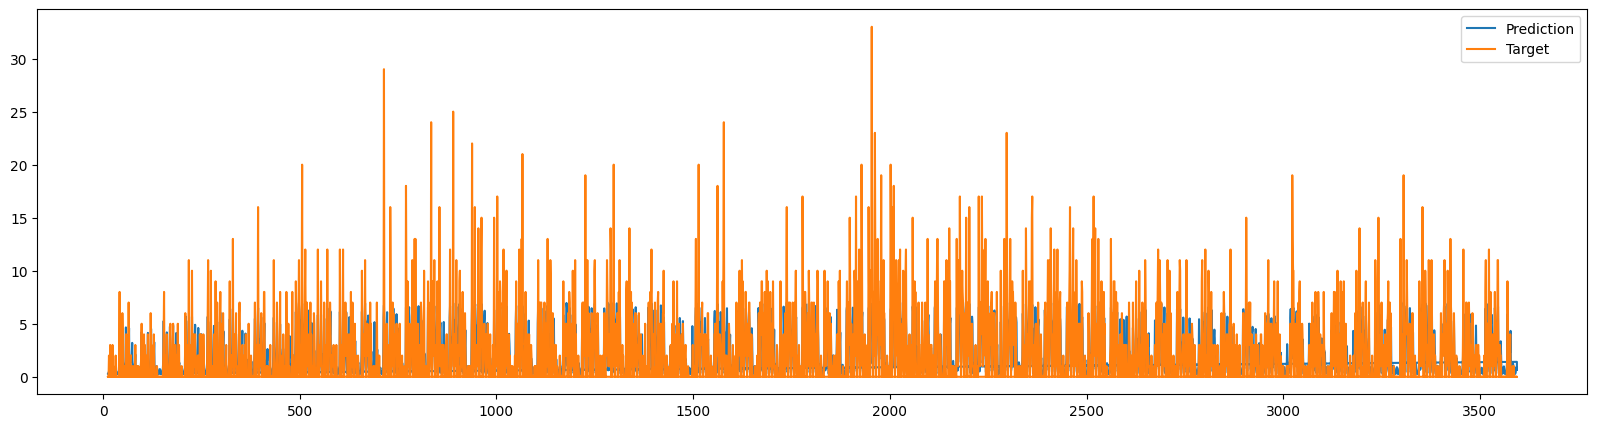

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns
# Plot predictions vs targets with lines
plt.figure(figsize=(20, 5))
plt.plot(evaluation_df['time_idx'], evaluation_df['predictions'], label='Prediction')
plt.plot(evaluation_df['time_idx'], evaluation_df['true_values'], label='Target')
plt.legend()
plt.show()

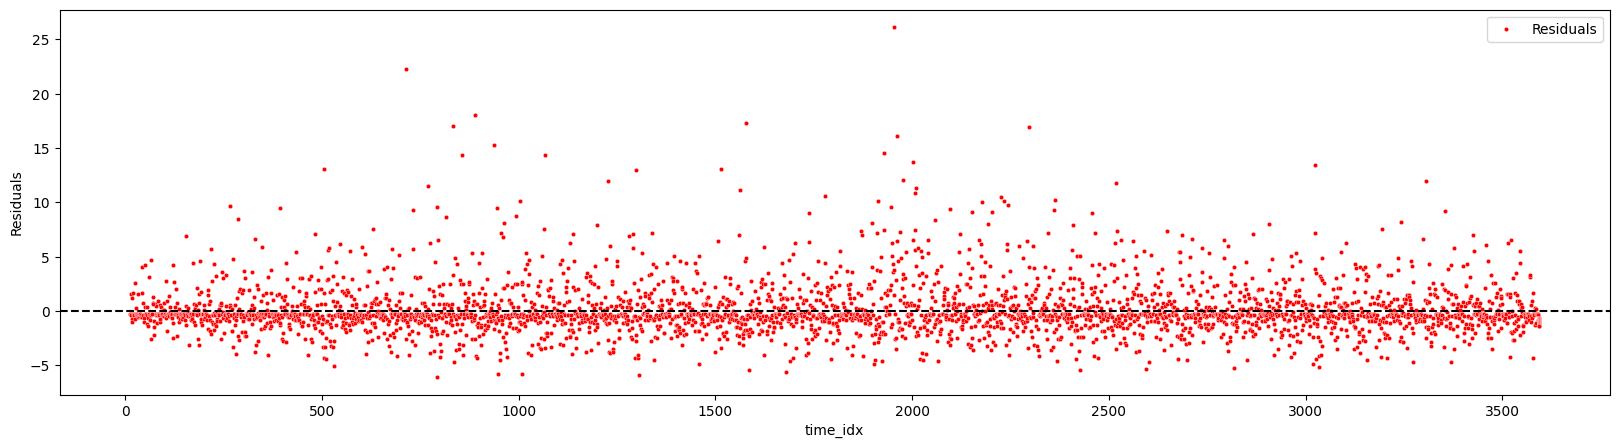

In [ ]:
# Plot the residuals

residuals = evaluation_df['true_values'] - evaluation_df['predictions']
plt.figure(figsize=(20, 5))
sns.scatterplot(x=evaluation_df['time_idx'], y=residuals, label='Residuals', color='red', s=10)
plt.axhline(0, color='black', linestyle='--')
plt.ylabel('Residuals')
plt.legend()
plt.show()

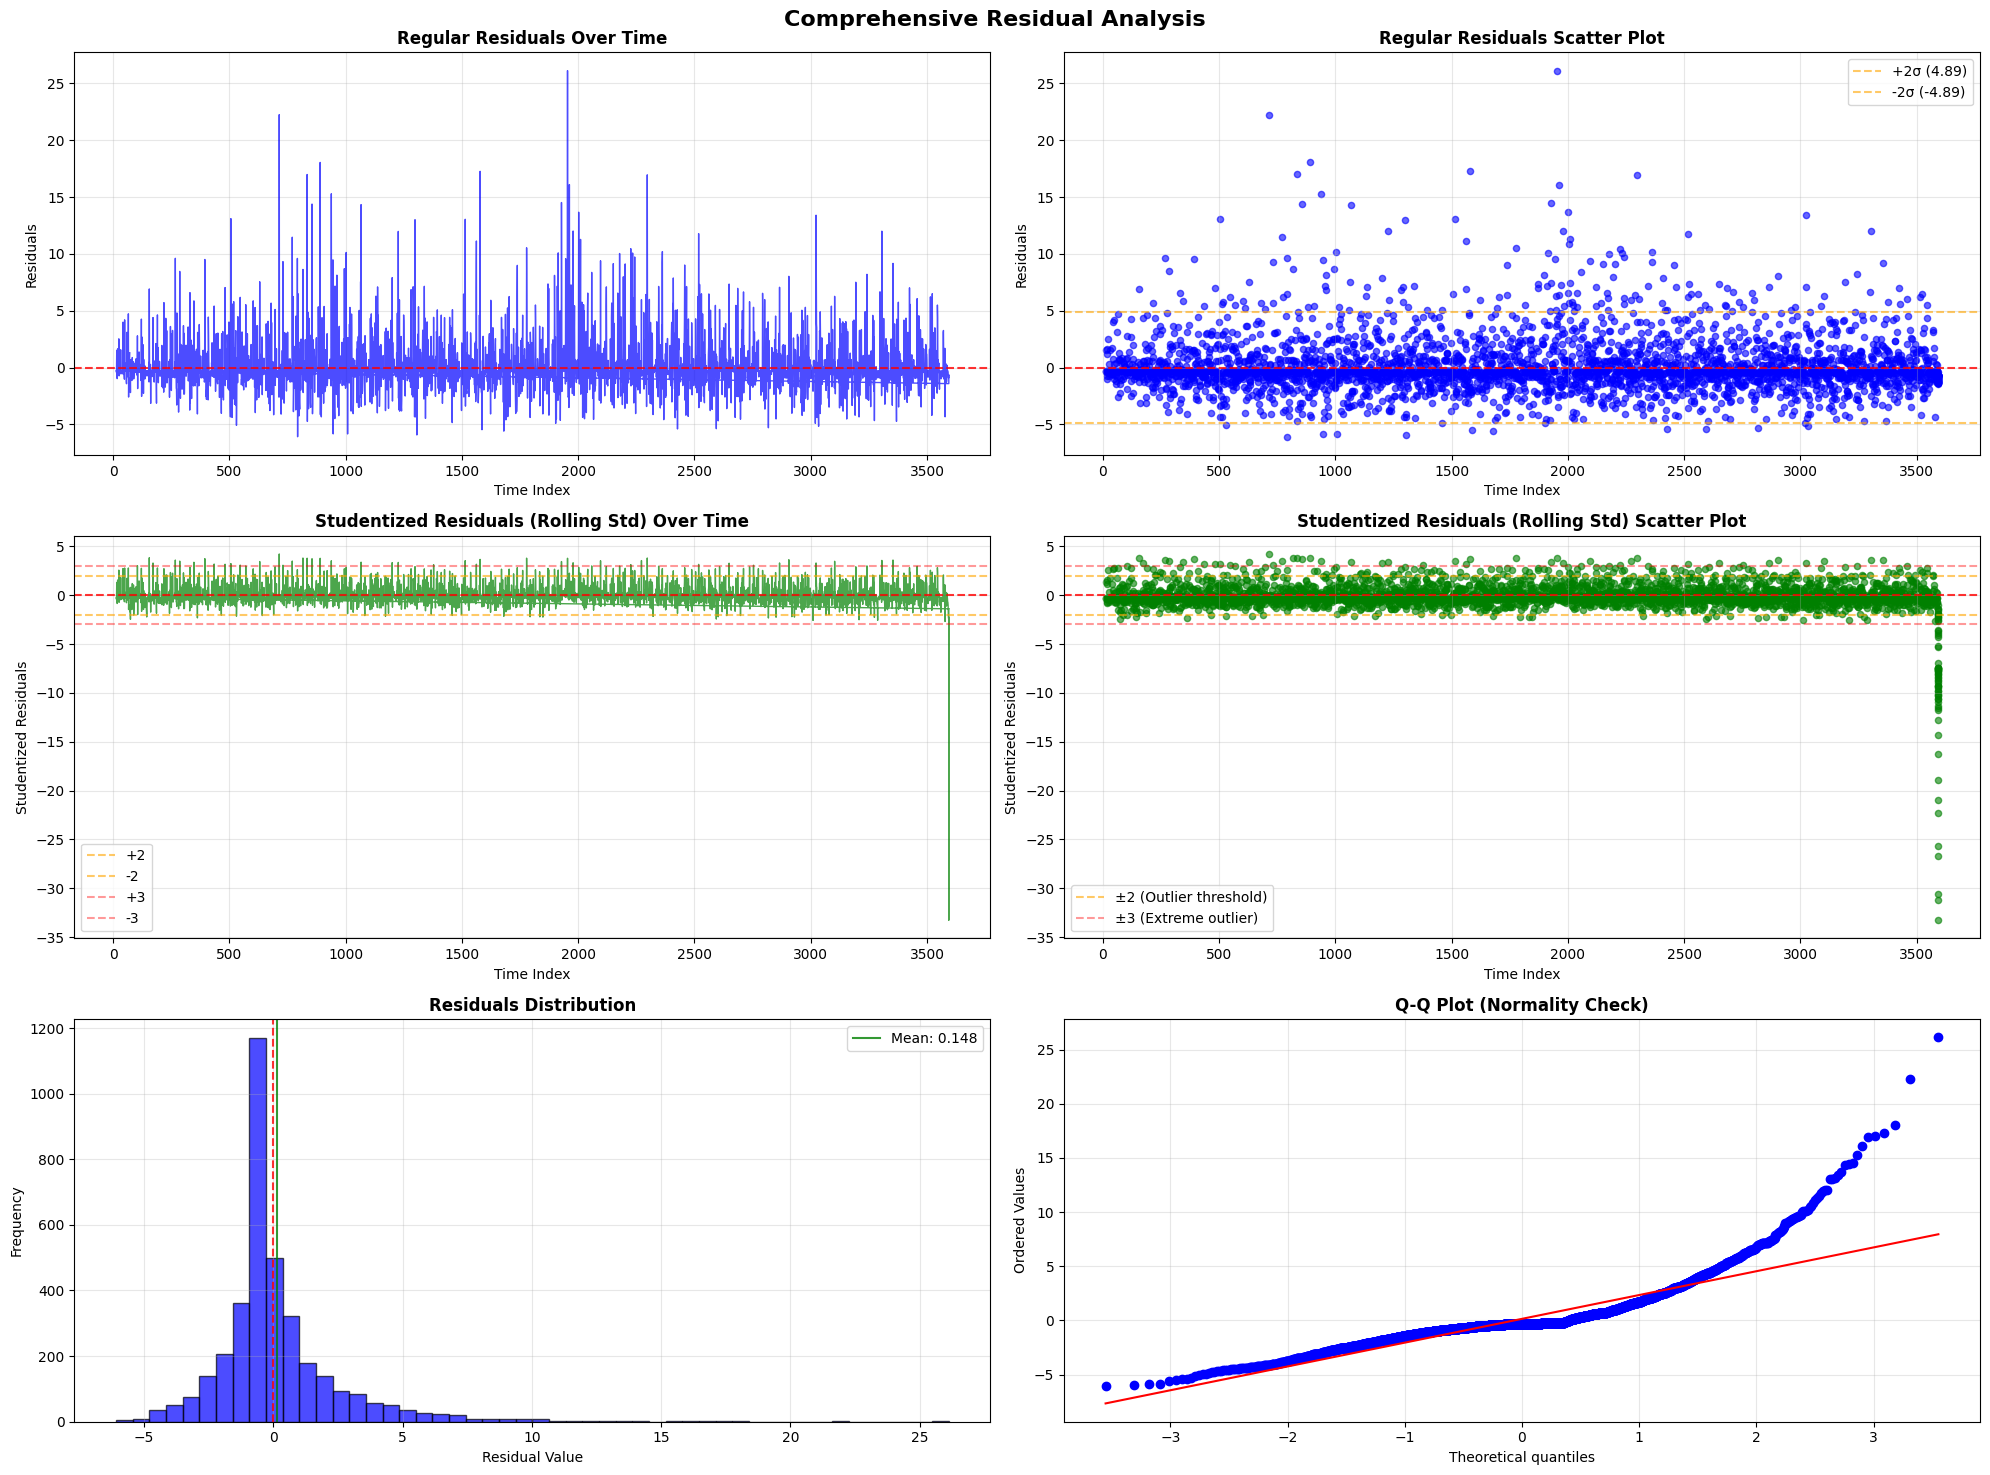

RESIDUAL ANALYSIS SUMMARY
Number of observations: 3643
Mean of residuals: 0.1475
Standard deviation of residuals: 2.4453
Min residual: -6.0816
Max residual: 26.1272
Skewness: 2.4613
Kurtosis: 12.7380

Outlier Analysis (Studentized Residuals):
Points beyond ±2σ: 255 (7.0%)
Points beyond ±3σ: 96 (2.6%)

Extreme outlier time indices: [104 155 171 267 286 347 394 434 481 506]...


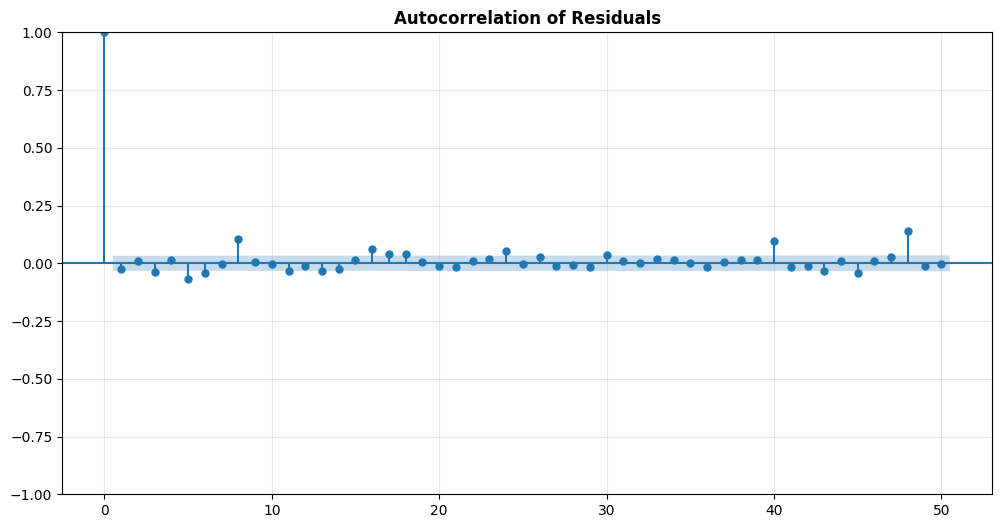


Autocorrelation analysis helps identify if residuals have temporal patterns.
Significant autocorrelation indicates the model may not capture all temporal dependencies.


In [ ]:
# Enhanced Residual Analysis: Regular and Studentized Residuals

import scipy.stats as stats
import warnings
warnings.filterwarnings('ignore')

# Calculate residuals
residuals = evaluation_df['true_values'] - evaluation_df['predictions']

# Calculate studentized residuals
# Studentized residuals = residuals / sqrt(MSE * (1 - h_ii))
# where h_ii is the leverage (diagonal of hat matrix)

# For simplicity, we'll use a rolling standard deviation approach
# This approximates studentized residuals for time series data
residual_std = residuals.rolling(window=20, center=True, min_periods=5).std()
studentized_residuals = residuals / (residual_std + 1e-8)  # Add small epsilon to avoid division by zero

# Alternative: Use overall standard deviation for studentized residuals
overall_std = residuals.std()
studentized_residuals_simple = residuals / overall_std

# Create comprehensive residual analysis plots
fig, axes = plt.subplots(3, 2, figsize=(20, 15))
fig.suptitle('Comprehensive Residual Analysis', fontsize=16, fontweight='bold')

# 1. Regular Residuals Time Series
axes[0, 0].plot(evaluation_df['time_idx'], residuals, 'b-', alpha=0.7, linewidth=1)
axes[0, 0].axhline(y=0, color='red', linestyle='--', alpha=0.8)
axes[0, 0].set_title('Regular Residuals Over Time', fontweight='bold')
axes[0, 0].set_xlabel('Time Index')
axes[0, 0].set_ylabel('Residuals')
axes[0, 0].grid(True, alpha=0.3)

# 2. Regular Residuals Scatter Plot
axes[0, 1].scatter(evaluation_df['time_idx'], residuals, alpha=0.6, s=20, color='blue')
axes[0, 1].axhline(y=0, color='red', linestyle='--', alpha=0.8)
axes[0, 1].axhline(y=2*np.std(residuals), color='orange', linestyle='--', alpha=0.6, label=f'+2σ ({2*np.std(residuals):.2f})')
axes[0, 1].axhline(y=-2*np.std(residuals), color='orange', linestyle='--', alpha=0.6, label=f'-2σ ({-2*np.std(residuals):.2f})')
axes[0, 1].set_title('Regular Residuals Scatter Plot', fontweight='bold')
axes[0, 1].set_xlabel('Time Index')
axes[0, 1].set_ylabel('Residuals')
axes[0, 1].legend()
axes[0, 1].grid(True, alpha=0.3)

# 3. Studentized Residuals (Rolling Std) Time Series
axes[1, 0].plot(evaluation_df['time_idx'], studentized_residuals, 'g-', alpha=0.7, linewidth=1)
axes[1, 0].axhline(y=0, color='red', linestyle='--', alpha=0.8)
axes[1, 0].axhline(y=2, color='orange', linestyle='--', alpha=0.6, label='+2')
axes[1, 0].axhline(y=-2, color='orange', linestyle='--', alpha=0.6, label='-2')
axes[1, 0].axhline(y=3, color='red', linestyle='--', alpha=0.4, label='+3')
axes[1, 0].axhline(y=-3, color='red', linestyle='--', alpha=0.4, label='-3')
axes[1, 0].set_title('Studentized Residuals (Rolling Std) Over Time', fontweight='bold')
axes[1, 0].set_xlabel('Time Index')
axes[1, 0].set_ylabel('Studentized Residuals')
axes[1, 0].legend()
axes[1, 0].grid(True, alpha=0.3)

# 4. Studentized Residuals (Rolling Std) Scatter Plot
axes[1, 1].scatter(evaluation_df['time_idx'], studentized_residuals, alpha=0.6, s=20, color='green')
axes[1, 1].axhline(y=0, color='red', linestyle='--', alpha=0.8)
axes[1, 1].axhline(y=2, color='orange', linestyle='--', alpha=0.6, label='±2 (Outlier threshold)')
axes[1, 1].axhline(y=-2, color='orange', linestyle='--', alpha=0.6)
axes[1, 1].axhline(y=3, color='red', linestyle='--', alpha=0.4, label='±3 (Extreme outlier)')
axes[1, 1].axhline(y=-3, color='red', linestyle='--', alpha=0.4)
axes[1, 1].set_title('Studentized Residuals (Rolling Std) Scatter Plot', fontweight='bold')
axes[1, 1].set_xlabel('Time Index')
axes[1, 1].set_ylabel('Studentized Residuals')
axes[1, 1].legend()
axes[1, 1].grid(True, alpha=0.3)

# 5. Residuals Distribution Histogram
axes[2, 0].hist(residuals, bins=50, alpha=0.7, color='blue', edgecolor='black')
axes[2, 0].axvline(x=0, color='red', linestyle='--', alpha=0.8)
axes[2, 0].axvline(x=np.mean(residuals), color='green', linestyle='-', alpha=0.8, label=f'Mean: {np.mean(residuals):.3f}')
axes[2, 0].set_title('Residuals Distribution', fontweight='bold')
axes[2, 0].set_xlabel('Residual Value')
axes[2, 0].set_ylabel('Frequency')
axes[2, 0].legend()
axes[2, 0].grid(True, alpha=0.3)

# 6. Q-Q Plot for Normality Check
stats.probplot(residuals, dist="norm", plot=axes[2, 1])
axes[2, 1].set_title('Q-Q Plot (Normality Check)', fontweight='bold')
axes[2, 1].grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

# Statistical Summary
print("=" * 60)
print("RESIDUAL ANALYSIS SUMMARY")
print("=" * 60)
print(f"Number of observations: {len(residuals)}")
print(f"Mean of residuals: {np.mean(residuals):.4f}")
print(f"Standard deviation of residuals: {np.std(residuals):.4f}")
print(f"Min residual: {np.min(residuals):.4f}")
print(f"Max residual: {np.max(residuals):.4f}")
print(f"Skewness: {stats.skew(residuals):.4f}")
print(f"Kurtosis: {stats.kurtosis(residuals):.4f}")

# Outlier detection using studentized residuals
outliers_2sigma = np.abs(studentized_residuals) > 2
outliers_3sigma = np.abs(studentized_residuals) > 3

print(f"\nOutlier Analysis (Studentized Residuals):")
print(f"Points beyond ±2σ: {np.sum(outliers_2sigma)} ({100*np.mean(outliers_2sigma):.1f}%)")
print(f"Points beyond ±3σ: {np.sum(outliers_3sigma)} ({100*np.mean(outliers_3sigma):.1f}%)")

# Identify potential outlier time indices
if np.sum(outliers_3sigma) > 0:
    outlier_indices = evaluation_df['time_idx'][outliers_3sigma].values
    print(f"\nExtreme outlier time indices: {outlier_indices[:10]}{'...' if len(outlier_indices) > 10 else ''}")

# Autocorrelation of residuals (for time series)
from statsmodels.graphics.tsaplots import plot_acf
fig, ax = plt.subplots(figsize=(12, 6))
plot_acf(residuals, lags=50, ax=ax, alpha=0.05)
ax.set_title('Autocorrelation of Residuals', fontweight='bold')
ax.grid(True, alpha=0.3)
plt.show()

print("\nAutocorrelation analysis helps identify if residuals have temporal patterns.")
print("Significant autocorrelation indicates the model may not capture all temporal dependencies.")